First iteration of vertical recharge from floodplain inundation. Read in output from manning's equation depths estimated previously and use to calculate vertical hydraulic gradient. Assume recharge causes negligible flow losses such that no iterative calculation of flow to depth for the downstream segment is needed. Vertical conductivity is estimated with the 2m of TPROGs data below ground surface.

In [1]:
# standard python utilities
import os
from os.path import basename, dirname, exists, join
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm



In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
git_dir = join(doc_dir,'GitHub','CosumnesRiverRecharge')
# dir of all gwfm data
gwfm_dir = join(dirname(doc_dir),'Box/research_cosumnes/GWFlowModel')

def add_path(fxn_dir):
    if fxn_dir not in sys.path:
        sys.path.append(fxn_dir)
        
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)

import flopy 
import flopy.utils.binaryfile as bf

add_path(doc_dir+'/GitHub/CosumnesRiverRecharge/tprogs_utilities')
add_path(doc_dir+'/GitHub/CosumnesRiverRecharge/python_utilities')

In [3]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

# tprogs_id = '' # original tprogs with conditioning data in output tsim
tprogs_id = '_no_conditioning'

data_dir = box_dir+ tprogs_id+'/data_output/'
fig_dir = box_dir+tprogs_id+'/figures/'

chan_dir = box_dir+'channel_data/'
gis_dir = chan_dir+'GIS/'

In [4]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/'
model_ws = loadpth+'Permeameter_for_velocity' + tprogs_id

In [5]:
name = 'MF.nam'
# name = 'MF_child.nam'
# m = flopy.modflow.Modflow.load(name, model_ws=model_ws, 
#                                 exe_name='mf2005', version='mf2005')


In [6]:
# nrow = m.dis.nrow
# nlay = m.dis.nlay
# ncol = m.dis.ncol
delr, delc =  200, 200

nlay, nrow,ncol = 320, 100,230

# Load data

In [8]:
# grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')
grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
# load sacramento river, creeks
rivers = gpd.read_file(gwfm_dir+'/SFR_data/Sac_valley_rivers/Sac_valley_rivers.shp')
cr = gpd.overlay(rivers.loc[rivers.GNIS_Name=='Cosumnes River'].to_crs('epsg:32610'), m_domain)

In [9]:
import h5py
f = h5py.File(join(chan_dir, 'setback_locs.hdf5'), "r")
local_str_setbacks = f['setbacks']['local'][:]
str_setbacks = f['setbacks']['regional'][:]

f.close()

In [10]:
# location of XS
xs_all = pd.read_csv(chan_dir+'/XS_point_elevations.csv',index_col=0)
# cross-sections smoothed in the center at 2km distance
xs_levee_smooth = pd.read_csv(chan_dir+'xs_levee_smooth.csv', index_col='dist_from_right_m')


In [11]:
# smoothed cross-section at every 200 m
xs_levee_smooth200 = pd.read_csv(chan_dir+'xs_levee_smooth_subsegments.csv', index_col='dist_from_right_m')


# Identify XS to grid cells

In [12]:
xs_gdf = gpd.GeoDataFrame(xs_all, geometry = gpd.points_from_xy(xs_all.Easting, xs_all.Northing), crs='epsg:32610')

In [13]:
transg = gpd.read_file(gis_dir+'/transect_lines.shp')
def transect2arr(transg, grid_p):
    """
    Given transects (transg : geodataframe of polylines) identify the corresponding
    model grid cells (grid_p:geodataframe of polygons) to create an array mapping XS number
    """
    transg_box = transg.copy()
    # upstream buffer only, seepage connects upstream to downstream cross-section
    transg_box['geometry'] = transg_box.buffer(-3000, single_sided=True)

    # overlay transect with grid to identify XS number for each row, col
    grid_xs = gpd.sjoin(grid_p, transg_box)
    # dissolve and find minimum assuming upstream reach is already covered by previous XS
    grid_xs = grid_xs.dissolve('node','min')
    # map XS number to an array for identifying which recharge goes to which XS number
    xs_arr = np.full((nrow, ncol), np.NaN)
    xs_arr[grid_xs.row-1, grid_xs.column-1] = grid_xs.line
    return(xs_arr)

xs_arr = transect2arr(transg, grid_p)



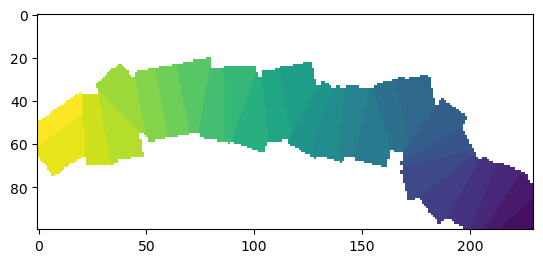

In [14]:
plt.imshow(xs_arr)
# np.savetxt(chan_dir+'XS_num_grid_reference.tsv', xs_arr, delimiter='\t')

# Calculate the XS minimum elevations

In [15]:
transg200 = gpd.read_file(gis_dir+'/transect_lines_subsegments.shp')

xs_arr200 = transect2arr(transg200, grid_p)

In [16]:
zs = gpd.read_file(gwfm_dir+'/DIS_data/grid_elevation_m_statistics.shp')
# columns with different quantiles 0 to 100% of elevation
q_cols = zs.columns[zs.columns.str.contains('perc')]
df_elevs = zs[q_cols]

# convert quantile dataframe to a 3D array
arr_elev = np.zeros((df_elevs.shape[1], zs.row.max(),zs.column.max()))
for n in np.arange(0,df_elevs.shape[1]):
    arr_elev[n, zs.row-1, zs.column-1] = df_elevs.iloc[:,n]

In [17]:
sfr_min = arr_elev[-1,grid_sfr.row.values.astype(int)-1, grid_sfr.column.values.astype(int)-1]


There needs to be a choice between having a linear, continuous water surface or having true ground elevations. Having a linear continuous elevation is a requirement with the kinematic wave when assuming continually downsloping channel and thus the slope being continually sloping. However in reality the cosumnes has an irregular flood elevation due to choke points, velocity changes, etc so it might be acceptable to assume a singular depth applies over irregular elevations with some discontinuities. 
An intermediate option would be a mostly linear downsloping channel but the bottom elevations after cleaning align closely.

An issue with creating a linearly sloping water surface is that when mapping out inundation there are cells that will be consistently inundated if any interpolated stream bed (xs_mins_arr) is above the original minimum (arr_elev 0th percentile).
I updated the subsegments minimum to follow this rule.

In [18]:
# find the corresponding minimum segment elevations from the raster sampled minimums
arr_elev_mins = np.zeros(len(np.unique(xs_arr200)[:-1]))
for n in np.unique(xs_arr200)[:-1].astype(int):
    arr_elev_mins[n] = np.min(arr_elev[0,xs_arr200==n])
#     print(n)


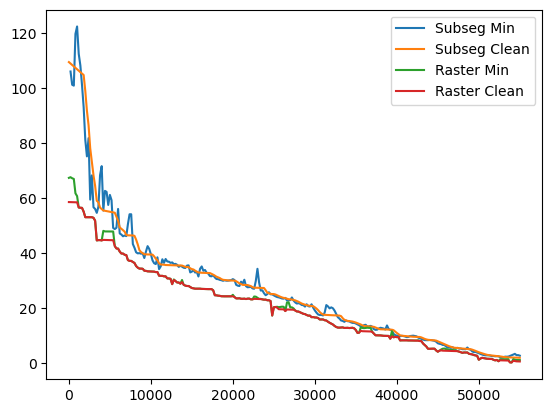

In [19]:
def linearize_xs_min(xs_mins, dline, window=2):
    """ 
    Clean up the XS minimums (xs_mins:dataframe) so they are always decreasing linearly,
    this ensures that the constant depth applied will lead to an approximately linear water surface elevation
    dline : distance between XS, used for slope 
    window : number of upstream or downstream points to use in rolling mean
    """
    # find minimum value in XS related to thalweg
    xs = pd.DataFrame(xs_mins, columns=['z_min'])
    #roling mean of 2 window centered removes any negative slope (manually tested)
    xs['z_min_cln'] = xs.rolling(window, center=False).mean()
    # if rolling mean set values greater than 5% above previous value, reset
    xs.loc[xs.z_min_cln > xs.z_min*1.01, 'z_min_cln'] =  xs.loc[xs.z_min_cln > xs.z_min*1.01, 'z_min']
    xs['z_min_cln'] = xs['z_min_cln'].rolling(window, center=False).mean()

    # calculate slope and fill NAs, fill slope with nearby
    z_cln_diff = xs.z_min_cln.diff().bfill()
    xs['slope'] = z_cln_diff.abs()/dline
    # # correct slope less than 1E-4
    xs.loc[xs.slope<1E-4,'slope'] = 1E-4
    # average out slope
    xs.loc[:,'slope'] = xs.loc[:,'slope'].rolling(window*4, center=False).min()
    xs.loc[:,'slope'] = xs.loc[:,'slope'].bfill().ffill()

    # fill NAs with original values
#     xs.loc[xs.z_min_cln.isna(),'z_min_cln'] = xs.loc[xs.z_min_cln.isna(),'z_min']
    
    for i in xs.index[-2::-1]:
    # fill NAs due to rolling mean, with backward filling
        if np.isnan(xs.loc[i,'z_min_cln']):
            xs.loc[i,'z_min_cln'] = xs.loc[i+1,'z_min_cln'] + xs.loc[i+1,'slope']*dline
        
#     fix str bot so all is downward sloping
    for i in xs.index[:-1]:
        if xs.loc[i+1,'z_min_cln'] >= xs.loc[i,'z_min_cln']:
            xs.loc[i+1,'z_min_cln'] = xs.loc[i,'z_min_cln'] - xs.loc[i,'slope']*dline

    return(xs)
xs_mins = np.nanmin(xs_levee_smooth.loc[3100:3300], axis=0)
xs = linearize_xs_min(xs_mins, dline=2000, window=2)

fig,ax=plt.subplots()

xs_plt = xs.set_index(np.arange(0,2000*xs.shape[0],2000))
# xs_plt.plot(y='z_min',label='Min',ax=ax)
# xs_plt.plot(y='z_min_cln',label='Clean',ax=ax)

xs_mins = np.nanmin(xs_levee_smooth200.loc[3100:3300], axis=0)
xs = linearize_xs_min(xs_mins, dline=200, window=5)

xs_plt = xs.set_index(np.arange(0,200*xs.shape[0],200))
xs_plt.plot(y='z_min',label='Subseg Min',ax=ax)
xs_plt.plot(y='z_min_cln',label='Subseg Clean',ax=ax)

# version based on raster minimum samples by grid cell
r = linearize_xs_min(arr_elev_mins, dline=200, window=5)
r_plt = r.set_index(np.arange(0,200*r.shape[0],200))
r_plt.plot(y='z_min',label='Raster Min',ax=ax)
r_plt['z_min_adj'] = np.where(r_plt.z_min_cln>r_plt.z_min, r_plt.z_min, r_plt.z_min_cln)
r_plt.plot(y='z_min_adj',label='Raster Clean',ax=ax)

# ax.plot(np.arange(0,200*sfr_min.shape[0],200), sfr_min, label='Quantile min')

plt.legend()

In [20]:
# create an array of minimum eleations tied to the cleaning mins above spread out to each subsegment
xs_mins_arr200 = np.full((nrow,ncol),np.nan)
for n in np.arange(0, len(xs)):
#     xs_mins_arr200[xs_arr200==n] = xs.z_min_cln[n] # sampled XS minimum
    xs_mins_arr200[xs_arr200==n] = r_plt.z_min_adj.values[n] # sampled grid cell minimum
    
# np.savetxt(chan_dir+'subsegments_xs_mins.tsv', xs_mins_arr200, delimiter='\t')

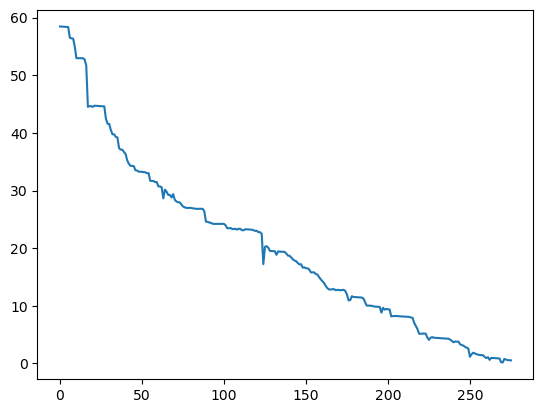

In [35]:
plt.plot(r_plt.z_min_adj.values)

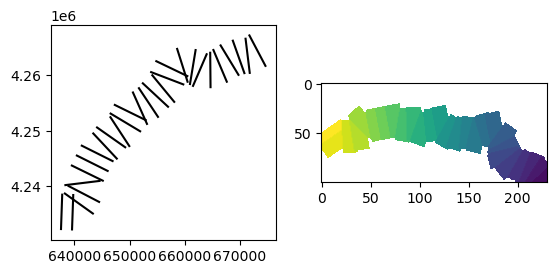

In [32]:
fig,axes=plt.subplots(1,2)
ax=axes[0]
# transg_box.plot('line', ax=ax)
transg.plot(ax=ax,color="black")
ax=axes[1]
ax.imshow(xs_arr)

In [35]:

doc_dir,
tprogs_fxn_dir = git_dir+'/tprogs_utilities'
if tprogs_fxn_dir not in sys.path:
    sys.path.append(tprogs_fxn_dir)
# sys.path
import tprogs_cleaning as tc
from tprogs_cleaning import  int_to_param, get_tprogs_for_elev
# from importlib import reload
# # importlib.reload
# reload(tc)

In [74]:
from numpy import ma
def tprogs_cut_elev(tprogs_line, dem_data, tprogs_info, **kwargs):
    """
    Parameters
    ----------
    tprogs_line : output from TPROGs of line data formatted to be converted by setting z then x then y
    dem_data : 2D array of elevation data of ground surface above which TPROGs should not be real
    rows : number of rows in the TPROGs model
    cols : number of columns in the TPROGs model
    """
    rows = kwargs.get('rows', np.where(np.ones(dem_data.shape)==1)[0])
    cols = kwargs.get('cols', np.where(np.ones(dem_data.shape)==1)[1])
    tprogs_elev = np.copy(np.reshape(tprogs_line,
                             (tprogs_info[-1], dem_data.shape[0], dem_data.shape[1])))
    # removed since analysis of HCP was not done with flipping of array
    # flip tprogs model along z axis to match modflow definition of 0 as top (TPROGS says 0 is bottom)
    # tprogs = np.flip(tprogs_elev,axis=0)
    # flip along x-axis as tprogs has bottom row as 0 and modflow has top row as 0
    # tprogs = np.flip(tprogs_elev,axis=1)
    # the bottom layer of the tprogs model is at -80 m amsl and the top layer is 80 m amsl
    delz = (tprogs_info[0] - tprogs_info[1])/tprogs_info[2]
    for t, k in enumerate(np.arange(tprogs_info[0],tprogs_info[1],-delz)):
        tprogs_elev[t,dem_data<k]= np.NaN

    masked_tprogs = ma.masked_invalid(tprogs_elev)
    return(masked_tprogs)

In [37]:
# mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final_no_conditioning/'

tprogs_files = glob.glob(mf_tprogs_dir+'*')

gel_dir = gwfm_dir+'/UPW_data'
if 'ZonePropertiesInitial.csv' in os.listdir(model_ws):
    print('exists')
    params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv',index_col='Zone')
else:
    params = pd.read_csv(gel_dir+'/ZonePropertiesInitial.csv',index_col='Zone')
    params.to_csv(model_ws+'/ZonePropertiesInitial.csv')
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400    

exists


In [39]:
# dem data for cropping above land surface
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_linear.tsv') # original file
dem_data_mean = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv')

In [49]:
zs = gpd.read_file(gwfm_dir+'/DIS_data/grid_elevation_m_statistics.shp')
# columns with different quantiles 0 to 100% of elevation
q_cols = zs.columns[zs.columns.str.contains('perc')]
df_elevs = zs[q_cols]

# convert quantile dataframe to a 3D array
arr_elev = np.zeros((df_elevs.shape[1], zs.row.max(),zs.column.max()))
for n in np.arange(0,df_elevs.shape[1]):
    arr_elev[n, zs.row-1, zs.column-1] = df_elevs.iloc[:,n]

In [48]:
from scipy.stats import gmean

tprogs_info = [80, -80, 320]


Text(0.5, 15.0, 'Setback distance (m)')

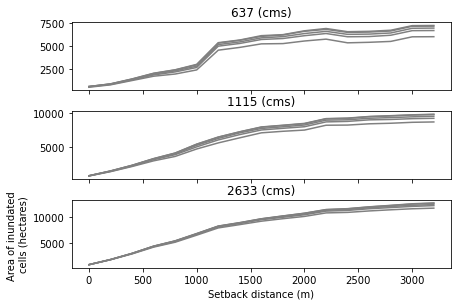

In [23]:
fig, ax = plt.subplots(3,1, sharex=True)
fig.tight_layout()
for i, Q_cfs in enumerate([22500, 39400, 93000]):
    fn = glob.glob(chan_dir+'*depth*'+str(Q_cfs)+'*')[0]
    d_arr_in = np.loadtxt(fn, delimiter='\t')
    d_arr = np.reshape(d_arr_in, (len(setbacks), m.dis.nrow, m.dis.ncol))
    ax[i].set_title(str(int(Q_cfs*0.3048**3))+' (cms)')
    for n in [0, 0.01,0.05, 0.1, 0.2]:
        num_cells = (d_arr>n).sum(axis=(1,2))*200*200
        ax[i].plot(setbacks, num_cells/1E4, color='gray')
    
        
# plt.legend(title='Flow (cms)')
plt.ylabel('Area of inundated \ncells (hectares)') #$m^2$
plt.xlabel('Setback distance (m)')


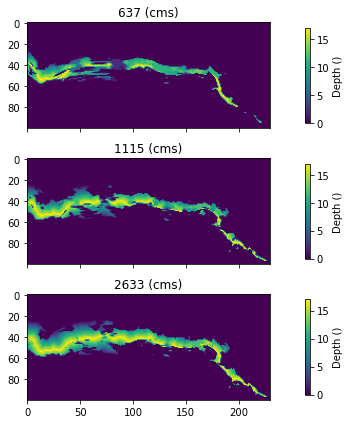

In [24]:
fig,axes = plt.subplots(3,1, figsize=(10,6), sharex=True)

for n,Q_cfs in enumerate([22500, 39400, 93000]):
    ax = axes[n]
    fn = glob.glob(chan_dir+'*depth*'+str(Q_cfs)+'*')[0]
    d_arr_in = np.loadtxt(fn, delimiter='\t')
    d_arr = np.reshape(d_arr_in, (len(setbacks), m.dis.nrow, m.dis.ncol))
    cellsbysetback = (d_arr>0).cumsum(axis=0)
    ax.set_title(str(int(Q_cfs*0.3048**3))+' (cms)')

    im = ax.imshow(cellsbysetback[-1,:,:])
    plt.colorbar(im, shrink=0.9, ax=ax, label='Depth ()')
fig.tight_layout()


In [57]:
Q_cfs = 22500
# Q_cfs = 39400
# Q_cfs = 93000

fn = glob.glob(box_dir+'depth_arrays/*depth*'+str(Q_cfs)+'*')[0]
d_arr_in = np.loadtxt(fn, delimiter='\t')
d_arr = np.reshape(d_arr_in, (len(setbacks), m.dis.nrow, m.dis.ncol))

The recharge estimates need to be an overlay of the flood depth arrays and teh high flow cell arrays so that we are activating cells known to connect to the deeper aquifer through the permeameter test. This method allows me to avoid running flood recharge scenarios in modflow and tracking recharge volumes to the aquifer.

**The original work with permeameters used the linear sampling DEM while the new work with Connec3D used the new DEM with mean sampling.**
- Most of the differences appear to be in locations where there are hills/more elevation variability. Maybe this didn't have a huge impact?

Also if the assumption of the analysis is that flow will route dominantly through the HCP then the soil zone thickness shouldn't matter necessarily.

In [45]:
# plt.imshow(dem_data-dem_data_mean,vmin=-2, vmax=2)
# plt.colorbar()


In [91]:
soil_K = np.zeros((100,nrow,ncol))
# a thicker soil layer reduces recharge
# from 1 to 2 to 3 m showed about 30-50% reduction each time
# using 2 meters would be more conservative than 1 m
soil_thick = 1
m_top = np.full((nrow,ncol), 80)
# m_top = m.dis.top
# top = dem_data
# bot_arr = dem_data - soil_thick
# fn = chan_dir+'/tprogs_geomK_'+str(soil_thick)+'m_depth.tsv'

top = dem_data_mean
bot_arr = dem_data_mean - soil_thick
fn = chan_dir+'/tprogs_geomK_'+str(soil_thick)+'m_depth_dem_mean.tsv'

# takes about 30 minutes to run through all 100 realizations
# since loading tprogs data is the slowest, it would be efficient to pre-process it into hydraulic conductivity arrays
if not os.path.exists(fn):
    tic_all = time.time()
    for t in np.arange(0,100):
        tic = time.time()
        tprogs_line = np.loadtxt(tprogs_files[t])
        masked_tprogs= tprogs_cut_elev(tprogs_line, m_top, tprogs_info)
        # these are rates in m/d
        K, Sy, Ss= int_to_param(masked_tprogs, params)


        soil_tprogs = get_tprogs_for_elev(K, top, bot_arr, tprogs_info)
        soil_K[t,:,:] = gmean(soil_tprogs,axis=0) 
        toc = time.time()
        print(t, end=' ')
    #     print('Realization', t,'done in %.2f sec' %(toc-tic), end=' ')
    toc_all = time.time()
    print('\nTotal time is %.2f minutes' %((toc_all-tic_all)/60))

    soil_K_out = np.reshape(soil_K, (100*nrow, ncol))
    np.savetxt(fn, soil_K_out, delimiter='\t')
else:
    soil_K_out = np.loadtxt(fn, delimiter='\t')
    soil_K = np.reshape(soil_K_out, (100, nrow, ncol))


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
Total time is 30.09 minutes


# Calculate example recharge
Start with pre-calculated depth array so no flow routing downstream.

In [25]:
def elev_to_tprogs_layers(elev, tprogs_top_elev, tprogs_bot_elev, num_lays):
    """
    function to get the tprogs layers based on the given elevation
    Example
    layer 0 is 80 meters, layer 1 is 79.5 meters, layer -1 is -80 meters
    """
    lay_thick = (tprogs_top_elev - tprogs_bot_elev)/num_lays
    elev_round = np.round((elev) * (1/lay_thick)) / (1/lay_thick) # dem rounded to the layer thickness
    elev_round[elev_round >= tprogs_top_elev] = tprogs_top_elev# any elevation above the top is set to the top
    # subtract the calculated row from top elev divided by layer thickness to get to index 0 at top and index 320 and bottom
    elev_indices = tprogs_top_elev/lay_thick - elev_round*(1/lay_thick) 
    return(elev_indices.astype(int))

# tprogs_cleaning.get_tprogs_for_elev(dem_data)
tprogs_lay = elev_to_tprogs_layers(elev=dem_data,tprogs_top_elev=80, tprogs_bot_elev=-80, num_lays=320)
# elev_to_tprogs_layers?
rows = np.where(np.ones(tprogs_lay.shape)==1)[0]
cols = np.where(np.ones(tprogs_lay.shape)==1)[1]

In [39]:
def highflow_at_groundsurface(run_ws, flow_percentile):
    ''' take Cell by Cell budget file and finds high flow cells by percentile
    then finds those that outcrop at ground surface'''
    cbb = flopy.utils.CellBudgetFile(run_ws+'/MF.cbc')
    # load velocity in z direction
    extcbb = flopy.utils.postprocessing.get_extended_budget(cbb)
    (qx, qy, qz) = flopy.utils.postprocessing.get_specific_discharge(vectors = extcbb, model=m)
    # convert flow to positive as it is all moving in the downward, -z direction
    # q = qz * -1 # not a good indicator at all
    # much better to use magntiude of velocity vector
    q = np.sqrt(qx**2 + qy**2 + qz**2)
    # split cells into low and high conductivity, based on chosen flow percentile
    q_lay = np.zeros(q.shape)
    q_lay[q >= np.percentile(q,flow_percentile)] = 1

    # get high conductivity at ground surface
    q_plt = np.zeros((100,230))
    q_plt[rows,cols] = q_lay[tprogs_lay[rows,cols],rows,cols] 

    return(q_plt)

In [27]:

def high_flow_arr(flow_percentile, str_setbacks):
    tic = time.time()
    # map the high flow cells for all 100 realizations
    hf_tot = np.zeros((100,nrow,ncol))

    for r in np.arange(0,100):
        print('Realization', r, ' time since start ',(time.time()-tic)/60)
        folder = '/realization'+ str(r).zfill(3)+'/'
        run_ws = model_ws+folder
        
        q_lay = highflow_at_groundsurface(run_ws, flow_percentile)
        # calculate total cells in each setback
        hf_tot[r,:,:] = q_lay

    # save counted high flow cells to a tsv
    hf_tot_out = np.reshape(hf_tot, (100*nrow,ncol))
    np.savetxt(data_dir+'surface_highflow_by_realization_'+str(flow_percentile)+'.tsv', hf_tot_out,delimiter = '\t')

    toc = time.time()
    print('Total time was', (toc-tic)/60, 'minutes')

In [41]:
high_flow_arr(87, str_setbacks)
# data_dir

Realization 0  time since start  0.0
Realization 1  time since start  0.13069162766138712
Realization 2  time since start  0.26248706579208375
Realization 3  time since start  0.39113149642944334
Realization 4  time since start  0.5270485003789266
Realization 5  time since start  0.6572938164075216
Realization 6  time since start  0.7872436165809631
Realization 7  time since start  0.917961327234904
Realization 8  time since start  1.0471189061800639
Realization 9  time since start  1.1786618789037069
Realization 10  time since start  1.307820733388265
Realization 11  time since start  1.4367173830668132
Realization 12  time since start  1.5671051502227784
Realization 13  time since start  1.6981863617897033
Realization 14  time since start  1.8299305438995361
Realization 15  time since start  1.9619639277458192
Realization 16  time since start  2.0929555177688597
Realization 17  time since start  2.224987558523814
Realization 18  time since start  2.3544143120447796
Realization 19  ti

In [91]:
flow_percentile=95
hf_tot_in =  np.loadtxt(data_dir+'surface_highflow_by_realization_'+str(flow_percentile)+'.tsv',delimiter = '\t')
hf_tot = np.reshape(hf_tot_in, (100, nrow, ncol))

In [97]:
rch_hf_sum = np.zeros((100,len(setbacks)))
rch_all_sum = np.zeros((100,len(setbacks)))


# since loading tprogs data is the slowest, it would be efficient to pre-process it into hydraulic conductivity arrays
for t in np.arange(0,100):

    # calculate vertical seepage with Darcy's equation assuming a saturated zone thickness similar to the lake bed in modflow
    # hydraulic conductivity is in m/day, hydraulic gradient is unitless, area is 200x200 m^2
    rch_hf_arr = -soil_K[t,:,:]*hf_tot[t,:,:] *(200*200)* ((d_arr + soil_thick)/soil_thick)
    # don't subset for high flow
    rch_all_arr = -soil_K[t,:,:]*(200*200)* ((d_arr + soil_thick)/soil_thick)

    # total recharge expected
    rch_hf_sum[t, :] = np.nansum(rch_hf_arr, axis=(1,2)).data
    rch_all_sum[t, :] = np.nansum(rch_all_arr, axis=(1,2)).data


In [187]:
rch_hf_sum = np.zeros((100,len(setbacks)))

# since loading tprogs data is the slowest, it would be efficient to pre-process it into hydraulic conductivity arrays
for t in np.arange(0,1):
    # calculate vertical seepage with Darcy's equation assuming a saturated zone thickness similar to the lake bed in modflow
    # hydraulic conductivity is in m/day, hydraulic gradient is unitless, area is 200x200 m^2
    rch_hf_arr = -soil_K[t,:,:]*hf_tot[t,:,:] *(200*200)* ((d_arr + soil_thick)/soil_thick)
    # total recharge expected
    rch_hf_sum[t, :] = np.nansum(rch_hf_arr, axis=(1,2)).data


In [215]:
# group recharge into upstream segments of each XS
xs_rch_sum = np.zeros((len(grid_xs.line.unique()),len(setbacks)))
for xs_n in grid_xs.line.unique():
    row = grid_xs[grid_xs.line==xs_n].row-1
    col = grid_xs[grid_xs.line==xs_n].column-1
    xs_rch_sum[xs_n,:] = np.nansum(rch_hf_arr[:,row,col], axis=1)

Text(0.5, 1.0, 'Filtered to high flow cells')

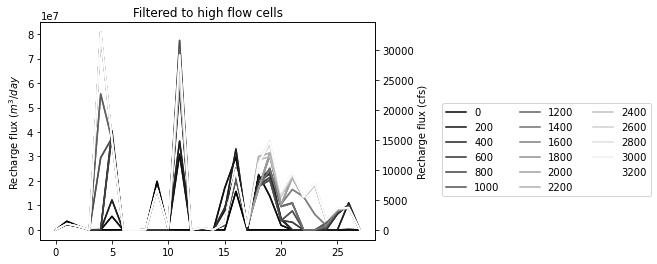

In [239]:
fig, ax = plt.subplots()
xs_rch_df = pd.DataFrame(xs_rch_sum*-1,columns = setbacks)
# xs_rch_df.plot(cmap='gray',  kind='bar', legend=True)
xs_rch_df.plot(cmap='gray',  legend=False, ax=ax)
plt.ylabel('Recharge flux ($m^3/day$')

ax2 = ax.twinx()
xs_rch_df.multiply((1/(86400 * 0.3048**3))).plot(cmap='gray', legend=False, ax=ax2)

plt.ylabel('Recharge flux (cfs)')
plt.legend(ncol=3, loc=(1.2,0.2))
plt.xlabel('Cross section')
plt.title('Filtered to high flow cells')


The combined flood depth-high flow cell recharge rates are ideal for optimizing compared to the TPROGs data alone. Additionally it is good to demonstrate that even with only using high flow cells the recharge rate is nearly equal what it would be with non-connected sands/gravels and fines.

Helen suggested including a loss factor to the flood as I route it downstream based on the expected amount recharged through high connectivity cells. I can use the muskingum routing set up from ECI273 and change the loss factor to be estimated with the recharge estimates. In this way it will become a sort of simple 1D model where upstream recharge will impact the downstream.

This analysis can be applied to local setbacks two ways:
1. (simple) apply the high flow cells included in the local setbacks to the flood depth maps
2. (complex) same as 1. but adjust flood depth maps to be impacted by local setback only.

Plotting the cumulative recharge vs streamflow will help identify if this amount is negligible loss compared to the flow and whether it is necessary to  adjust streamflow.

Text(0.5, 0, 'Setback distance (m)')

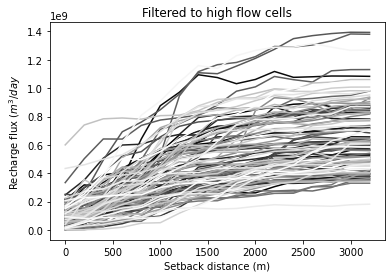

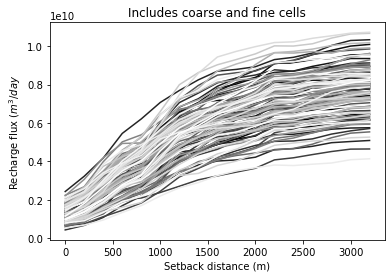

In [101]:
rch_sum_df = pd.DataFrame(rch_hf_sum*-1,columns = setbacks).transpose()
rch_sum_df.plot(cmap='gray', legend=False)
plt.ylabel('Recharge flux ($m^3/day$')
plt.xlabel('Setback distance (m)')
plt.title('Filtered to high flow cells')

rch_sum_df = pd.DataFrame(rch_all_sum*-1,columns = setbacks).transpose()
rch_sum_df.plot(cmap='gray', legend=False)
plt.title('Includes coarse and fine cells')
plt.ylabel('Recharge flux ($m^3/day$')
plt.xlabel('Setback distance (m)')